# Cargando y visualizando datos desde OpenStreetMap

### Se importan los modulos necesarios de Python

In [2]:
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import *
import matplotlib.pyplot as plt
import pyrosm
from pyrosm.data import sources


/home/jsepulveda/miniconda3/envs/myenv/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### Se carga el archivo .shp de Chile

In [11]:
pais = gpd.read_file('/home/jsepulveda/osm/chile-latest-free.shp.zip')
pais.head()

,osm_id,code,fclass,name,type,geometry
0,23393750,1500,building,Terminal de Buses Santiago,None,"POLYGON ((-70.68894 -33.45415, -70.68759 -33.4..."
1,23477423,1500,building,Alto Las Condes,retail,"POLYGON ((-70.54771 -33.39012, -70.54770 -33.3..."
2,23674761,1500,building,Cinepolis,None,"POLYGON ((-70.57129 -33.44724, -70.57090 -33.4..."
3,23675225,1500,building,Lider,None,"POLYGON ((-70.57850 -33.48625, -70.57850 -33.4..."
4,24402037,1500,building,Lider,None,"POLYGON ((-70.51295 -33.36918, -70.51288 -33.3..."


### Se carga el archivo .shp de la Región Metropolitana con las comunas urbanas

In [3]:
rm = gpd.read_file('/home/jsepulveda/urban_comunas.shp')
rm_clean = rm.drop(['REGION','NOM_REGION','PROVINCIA','NOM_PROVIN','COMUNA','SHAPE_Leng','SHAPE_Area'],axis=1)
rm_clean = rm_clean.set_crs("EPSG:4326")
rm_clean.head()

,NOM_COMUNA,geometry
0,PUDAHUEL,"POLYGON ((-70.78216 -33.41714, -70.78216 -33.4..."
1,CERRO NAVIA,"POLYGON ((-70.71927 -33.41334, -70.71888 -33.4..."
2,LAMPA,"POLYGON ((-70.71901 -33.32442, -70.71902 -33.3..."
3,HUECHURABA,"POLYGON ((-70.60223 -33.38550, -70.60222 -33.3..."
4,CONCHALÍ,"POLYGON ((-70.69041 -33.36579, -70.69028 -33.3..."


### Se intersectan ambos geodataframes para encontrar los POI de la RM

In [13]:
rm_osm = gpd.sjoin(pais,rm_clean, how='inner', op='intersects').reset_index().drop(['index_right','index'], axis = 1)
rm_osm.head()

,osm_id,code,fclass,name,type,geometry,NOM_COMUNA
0,23393750,1500,building,Terminal de Buses Santiago,None,"POLYGON ((-70.68894 -33.45415, -70.68759 -33.4...",ESTACIÓN CENTRAL
1,24964212,1500,building,Estación Central,train_station,"POLYGON ((-70.67941 -33.45270, -70.67929 -33.4...",ESTACIÓN CENTRAL
2,33102634,1500,building,Lider,None,"POLYGON ((-70.69281 -33.45195, -70.69197 -33.4...",ESTACIÓN CENTRAL
3,33102659,1500,building,Block 2,apartments,"POLYGON ((-70.69165 -33.44908, -70.69147 -33.4...",ESTACIÓN CENTRAL
4,33102661,1500,building,Block 8,apartments,"POLYGON ((-70.69058 -33.44786, -70.69051 -33.4...",ESTACIÓN CENTRAL


### Se printean los elementos de la RM por comuna

<AxesSubplot:>

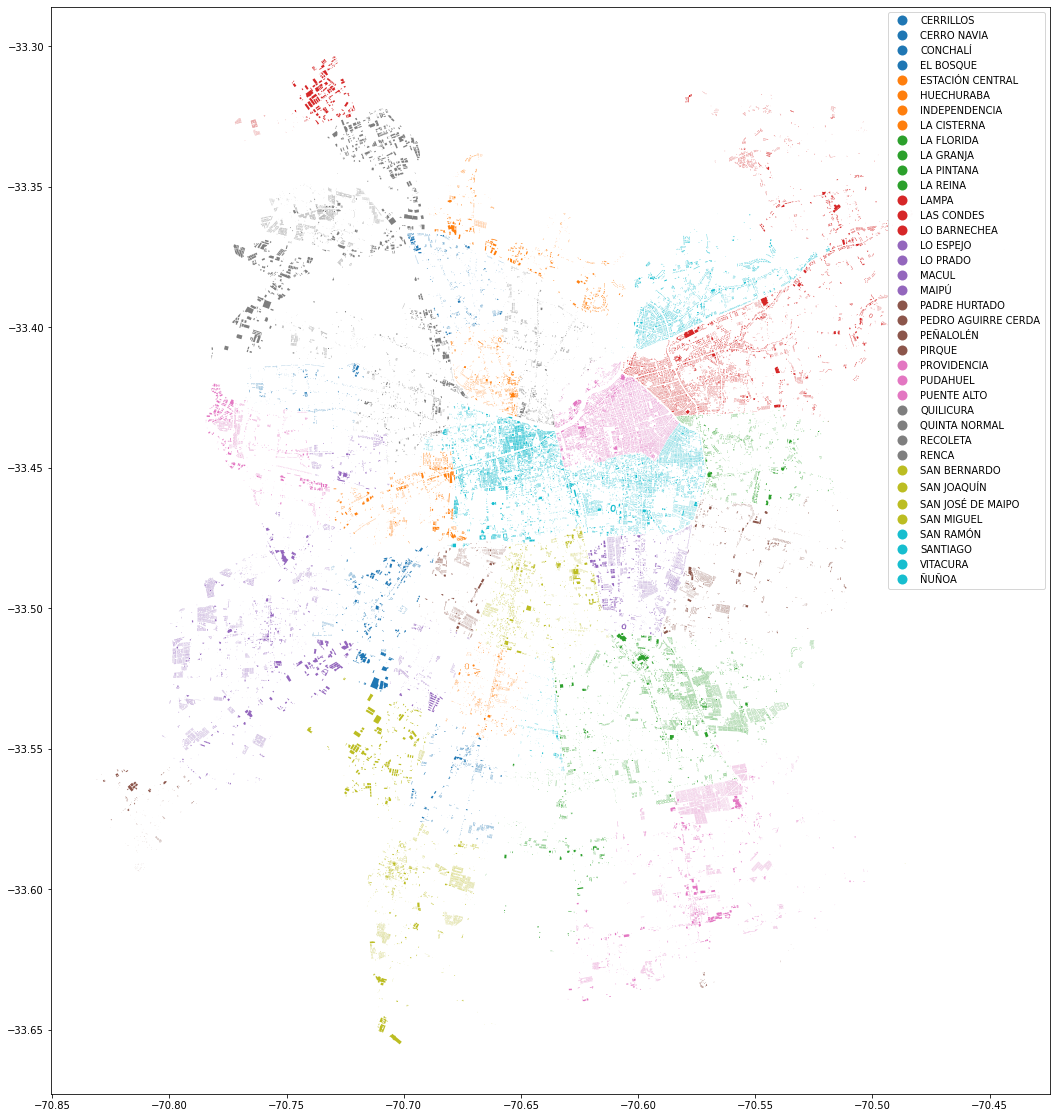

In [14]:
rm_osm.plot(figsize=(20,20), linewidth=5, column='NOM_COMUNA', legend=True)

# ##################################################################

### Se utiliza unary union para sacar el poligono de la RM

<AxesSubplot:>

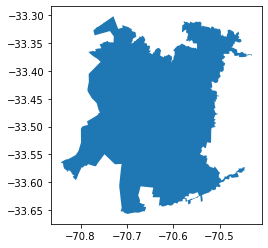

In [4]:
limites = rm_clean.geometry.unary_union
limites_gpd = gpd.GeoDataFrame(geometry=[limites],crs=rm_clean.crs)
limites_gpd.plot()

### Se lee el osm utilizando como bounding box el poligono de la RM

In [5]:
rm_osm = pyrosm.OSM('/home/jsepulveda/osm/chile-latest.osm.pbf', bounding_box = limites)

In [6]:
pois = rm_osm.get_pois()

In [9]:
pois.head()

,version,id,lat,lon,timestamp,tags,changeset,addr:city,addr:country,addr:full,...,information,museum,tourism,zoo,geometry,osm_type,cafe,school,water,wholesale
0,18,386313,-33.439552,-70.651115,1553390258,None,0.0,Santiago,None,None,...,None,None,None,None,POINT (-70.65112 -33.43955),node,NaN,NaN,NaN,NaN
1,7,133663460,-33.446224,-70.628487,1342745401,"{""alt_name"":""Ciudadano Restaurant""}",0.0,None,None,None,...,None,None,None,None,POINT (-70.62849 -33.44622),node,NaN,NaN,NaN,NaN
2,6,133769438,-33.446537,-70.614647,1525957984,None,0.0,Providencia,CL,None,...,None,None,None,None,POINT (-70.61465 -33.44654),node,NaN,NaN,NaN,NaN
3,7,223920407,-33.435596,-70.630402,1578789062,"{""wikidata"":""Q28501698""}",0.0,None,CL,None,...,None,None,museum,None,POINT (-70.63040 -33.43560),node,NaN,NaN,NaN,NaN
4,7,240434655,-33.376240,-70.525055,1398287198,None,0.0,Las Condes,CL,None,...,None,None,None,None,POINT (-70.52505 -33.37624),node,NaN,NaN,NaN,NaN


### Se muestran los POI segun su tipo de osm

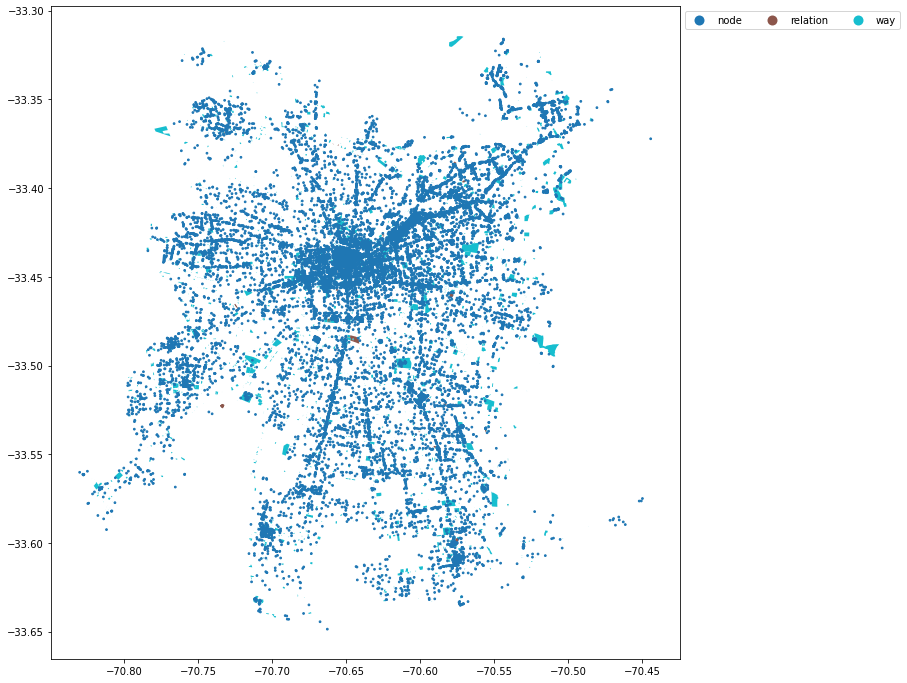

In [10]:
ax = pois.plot(column='osm_type', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))

### Se muestran los POI segun su comuna

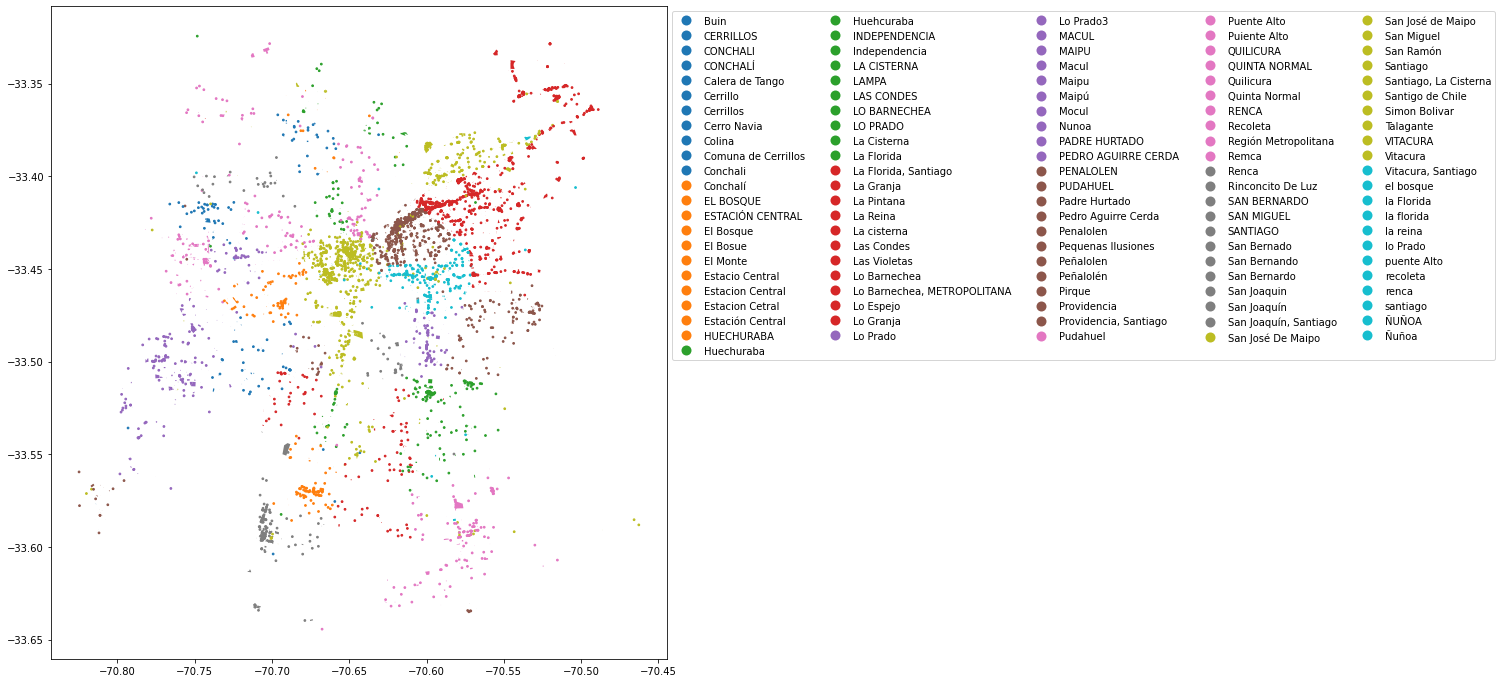

In [11]:
ax = pois.plot(column='addr:city', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))

### Se muestran los POI de la categoria turismo

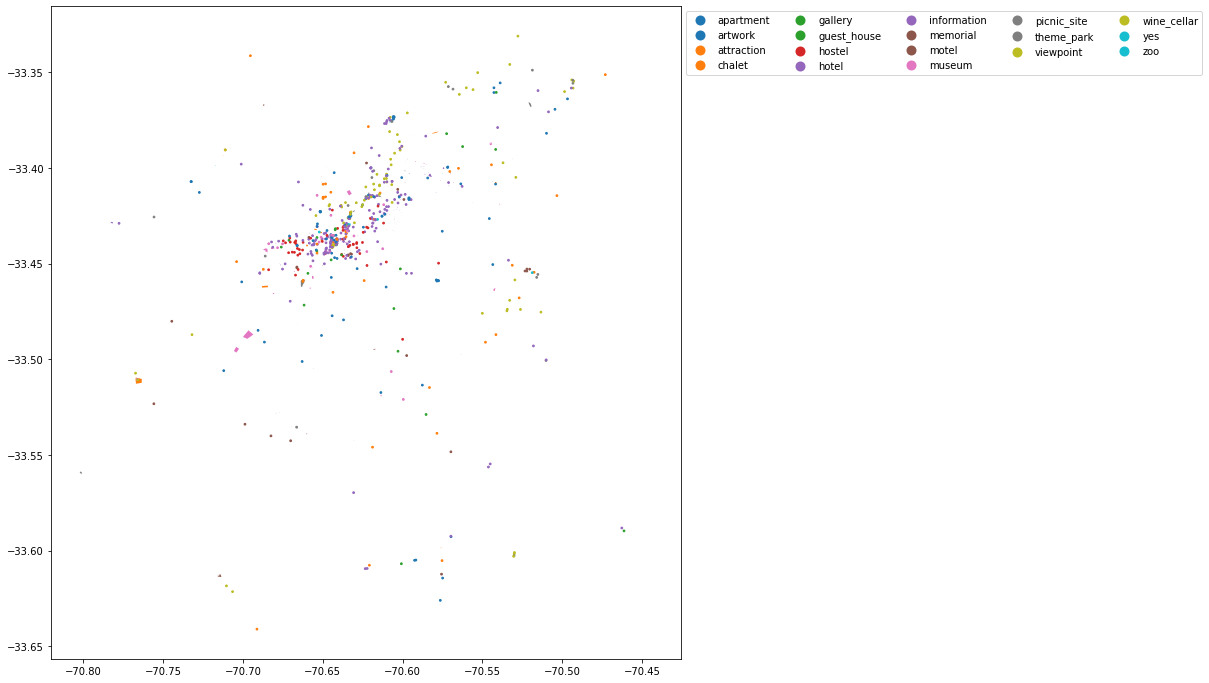

In [31]:
tourism = pois.dropna(subset=['tourism'])
ax = tourism.plot(column='tourism', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))

### Se muestran los POI de la categoria tiendas

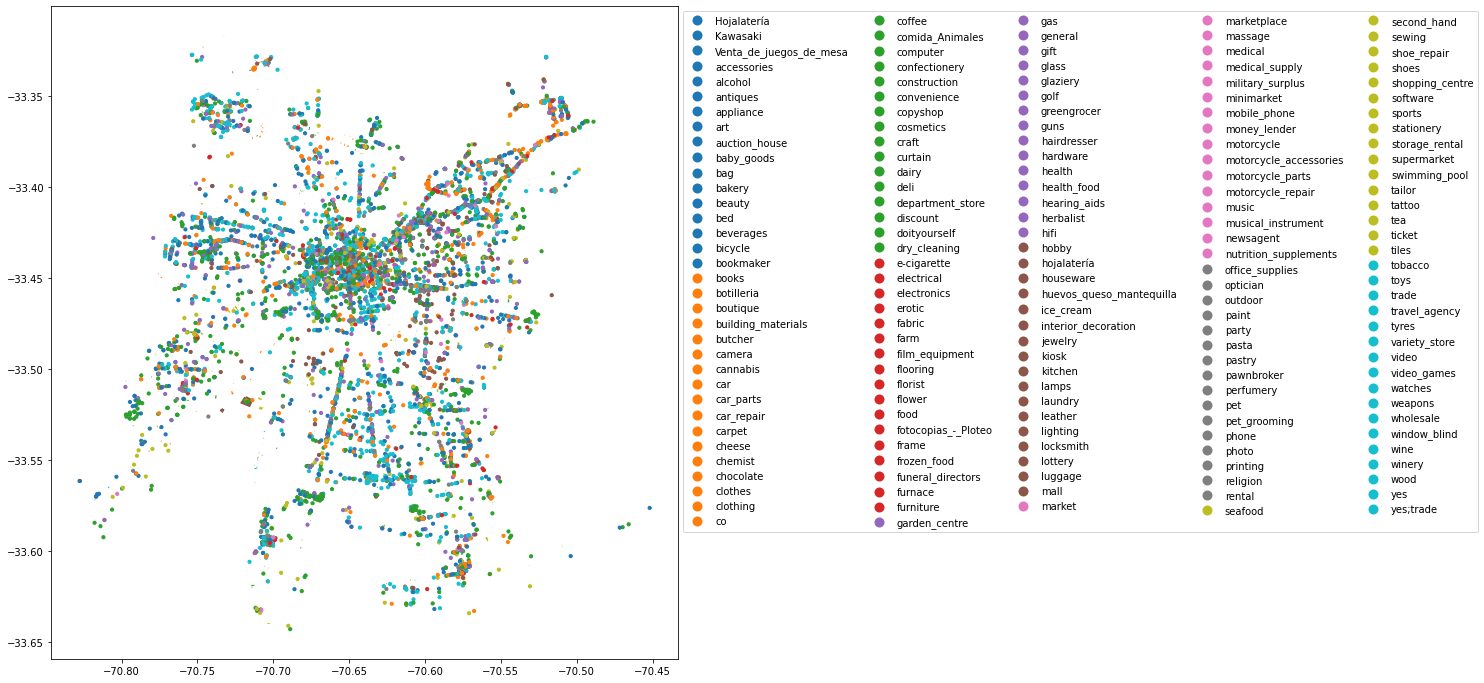

In [33]:
shop = pois.dropna(subset=['shop'])
ax = shop.plot(column='shop', markersize=10, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))

### Se muestran los POI de la categoria amenidad

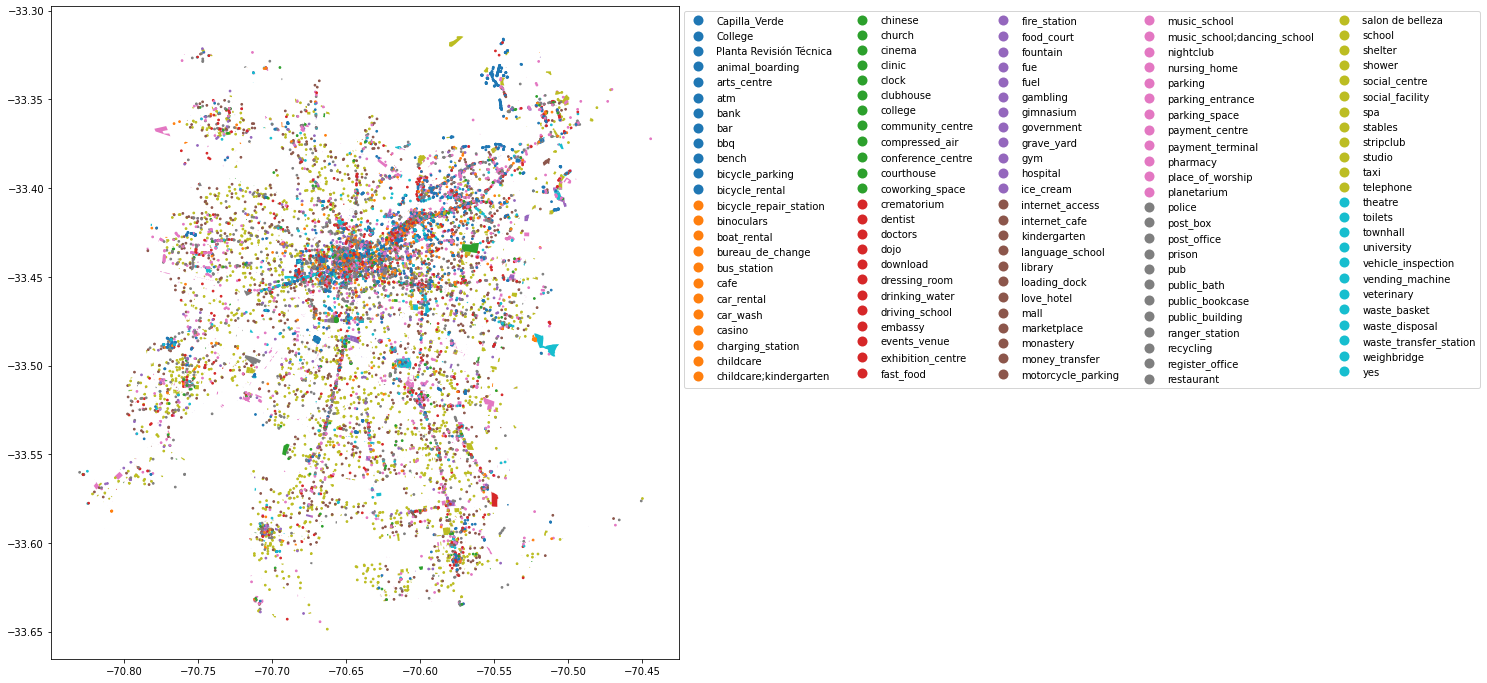

In [34]:
amenity = pois.dropna(subset=['amenity'])
ax = amenity.plot(column='amenity', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))